In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data
# import dataset with one-hot class encoding
mnist = input_data.read_data_sets("../data", one_hot=True)
def binarize(images, threshold=0.1):
    return (threshold < images).astype('float32')
X_train, X_test = binarize(mnist.train.images), binarize(mnist.test.images)
Y_train, Y_test = mnist.train.labels, mnist.test.labels
n_train = Y_train.shape[0]
n_labels = Y_train.shape[1]
n_pixels = X_train.shape[1]
models_folder = "../models"
epochs, train_errs, test_errs, train_losses, test_losses = [None] * 5
def create_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


In [9]:
# For drawing learning curves
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
def plot_learning_curve_error():
    global epochs, train_errs, test_errs
    plt.plot(epochs[:len(train_errs)], train_errs, label="Training error")
    plt.plot(epochs[:len(test_errs)], test_errs, label="Test error")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(8, 5)
def plot_learning_curve_loss():
    global epochs, train_losses, test_losses
    plt.plot(epochs[:len(train_losses)], train_losses, label="Training loss")
    plt.plot(epochs[:len(test_losses)], test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(8, 5)

Model training function (also saves model)

In [11]:
def train_rnn_classifier(n_units=32, c_type="LSTM", name="unnamed", lstm_forget_bias=1.0, print_logs=True,
                         n_epochs=10, batch_size=100, learning_rate=0.0001, dropout_keep_prob=0.85):
    global epochs, train_errs, test_errs, train_losses, test_losses
    
    # Hyperparameters
    n_relu_units = 100
    stacked_layers = 3

    # Define model
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, n_pixels])
    y_ = tf.placeholder("float", [None, n_labels])
    W_1 = tf.Variable(tf.truncated_normal([n_units, n_relu_units], stddev=0.1))
    b_1 = tf.Variable(tf.truncated_normal([n_relu_units], stddev=0.1))
    W_2 = tf.Variable(tf.truncated_normal([n_relu_units, n_labels], stddev=0.1))
    b_2 = tf.Variable(tf.truncated_normal([n_labels], stddev=0.1))
    x_tr = tf.reshape(x, [tf.shape(x)[0], n_pixels, 1])
    lstm = rnn.LSTMCell(n_units, forget_bias=lstm_forget_bias) if c_type[-4:] == "LSTM" else \
           rnn.GRUCell(n_units)
    keep_prob = tf.placeholder(tf.float32)
    lstm = rnn.DropoutWrapper(lstm, input_keep_prob=1.0, output_keep_prob=keep_prob)
    if c_type[:len("stacked")] == "stacked":
        lstm = rnn.MultiRNNCell([lstm] * stacked_layers)
    outputs, states = tf.nn.dynamic_rnn(lstm, x_tr, dtype=tf.float32)
    relu_1 = tf.nn.relu(tf.matmul(outputs[:, -1], W_1) + b_1)
    y = tf.nn.softmax(tf.matmul(relu_1, W_2) + b_2)
    saver = tf.train.Saver()

    # Define loss function & training step
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
#     train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

    # Define error computation
    y_p = tf.argmax(y, 1)
    y_g = tf.argmax(y_, 1)
    correct_prediction = tf.equal(y_p, y_g)
    error = 1.0 - tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    # Train model using minibatch SGD, saving only if test error decreased since last save (early stopping)
    create_folder(models_folder)
    create_folder(models_folder + "/" + name)
    best_test_error = float('inf')
    if os.path.exists(models_folder + "/" + name + "/" + name + ".index"):
        saver.restore(sess, models_folder + "/" + name + "/" + name)
        best_test_error = sess.run(error, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
    sess = tf.Session()
    sess.run(init)
    train_errs, test_errs, train_losses, test_losses = [], [], [], []
    epochs = list(range(1, 1 + n_epochs))
    train_indices = list(range(n_train))
    n_batches = n_train // batch_size
    
    for epoch in range(n_epochs):
        # Randomize training samples order
        random.shuffle(train_indices)
        for i in range(n_batches):
            batch_indices = train_indices[i * batch_size : (i + 1 + (1 if i == n_batches - 1 else 0)) * batch_size]
            batch_xs, batch_ys = X_train[batch_indices], Y_train[batch_indices]
            sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: dropout_keep_prob})
            
        train_err, train_loss = sess.run([error, cross_entropy], feed_dict={x: X_train, y_: Y_train, keep_prob: 1.0})
        test_err, test_loss = sess.run([error, cross_entropy], feed_dict={x: X_test, y_: Y_test, keep_prob: 1.0})
        if print_logs:
            print("Epoch " + str(epoch + 1) + ", Train error: " + str(train_err) + ", Test error: " + str(test_err) + \
                                              ", Train loss: " + str(train_loss) + ", Test loss: " + str(test_loss))
        train_errs += [train_err]
        test_errs += [test_err]
        train_losses += [train_loss]
        test_losses += [test_loss]

        # Early stopping
        if test_err < best_test_error:
            best_test_error = test_err
            saver.save(sess, models_folder + "/" + name + "/" + name)
            
    return min(test_errs)

Task 1a

In [8]:
train_rnn_classifier(n_units=32, c_type="LSTM", name="1a_32")

Epoch 1, Train error: 0.798582, Test error: 0.8037, Train loss: 2.21442, Test loss: 2.2161
Epoch 2, Train error: 0.747218, Test error: 0.7475, Train loss: 2.17193, Test loss: 2.17191
Epoch 3, Train error: 0.631873, Test error: 0.6313, Train loss: 2.12427, Test loss: 2.12149
Epoch 4, Train error: 0.633982, Test error: 0.6359, Train loss: 2.07979, Test loss: 2.07941
Epoch 5, Train error: 0.578855, Test error: 0.5818, Train loss: 2.0573, Test loss: 2.05834
Epoch 6, Train error: 0.577127, Test error: 0.5799, Train loss: 2.04525, Test loss: 2.04732
Epoch 7, Train error: 0.572582, Test error: 0.5798, Train loss: 2.0382, Test loss: 2.04239
Epoch 8, Train error: 0.574564, Test error: 0.5816, Train loss: 2.03669, Test loss: 2.03972
Epoch 9, Train error: 0.588018, Test error: 0.5954, Train loss: 2.05304, Test loss: 2.05803
Epoch 10, Train error: 0.583709, Test error: 0.592, Train loss: 2.04276, Test loss: 2.04738
Epoch 11, Train error: 0.592836, Test error: 0.5878, Train loss: 2.0546, Test loss:

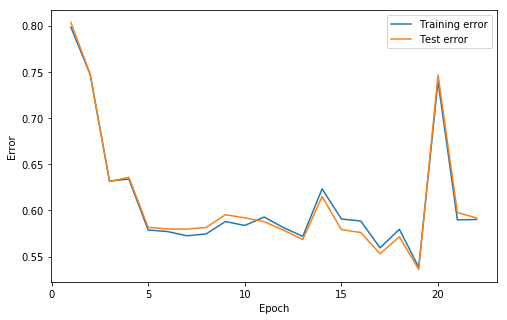

In [7]:
plot_learning_curve_error()

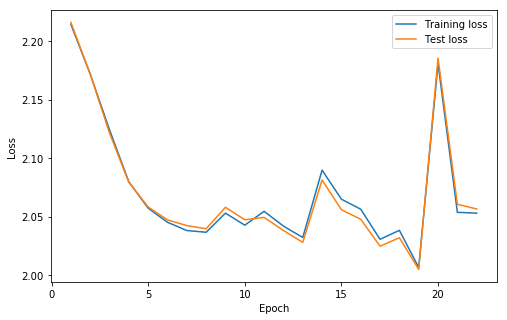

In [10]:
plot_learning_curve_loss()

In [ ]:
train_rnn_classifier(n_units=64, c_type="LSTM", name="1a_64")

Epoch 1, Train error: 0.807345, Test error: 0.8082, Train loss: 2.23046, Test loss: 2.23162


In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()

In [ ]:
train_rnn_classifier(n_units=128, c_type="LSTM", name="1a_128")

In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()

Task 1b

In [ ]:
train_rnn_classifier(n_units=32, c_type="GRU", name="1b_32")

In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()

In [ ]:
train_rnn_classifier(n_units=64, c_type="GRU", name="1b_64")

In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()

In [ ]:
train_rnn_classifier(n_units=128, c_type="GRU", name="1b_128")

In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()

Task 1c

In [ ]:
train_rnn_classifier(c_type="stacked_LSTM", name="1c")

In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()

Task 1d

In [ ]:
train_rnn_classifier(c_type="stacked_GRU", name="1d")

In [ ]:
plot_learning_curve_error()

In [ ]:
plot_learning_curve_loss()